In [1]:
import time
from tqdm import tqdm
import argparse
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from options.explain_options import ExplainOptions
from datasets.imagenet_dataset import ImageNetDataset
from explanations.bhem_explanation import BhemExplanation, layer
from util.color import red_transparent_blue

In [2]:
sys.argv = ['notebook']

In [3]:
# parser = argparse.ArgumentParser(description='Example parser')
# parser.add_argument('--dataroot', type=str, default= "./data/tiny-imagenet")
# parser.add_argument('--model', type=str, default= "res_class")
# parser.add_argument('--gpu_ids', type=str, default= "mps")
# parser.add_argument('--name', type=str, default= "Resnet50onImageNet")
# parser.add_argument('--net_name', type=str, default= "resnet50")
# parser.add_argument('--dataset_name', type=str, default= "imagenet")
# parser.add_argument('--phase', type=str, default= "val")
# parser.add_argument('--explanation_name', type=str, default= "bhem")
# parser.add_argument('--epoch', type=str, default= "15")
# parser.add_argument('--isTrain', type=bool, default= False)
# parser.add_argument('--checkpoints_dir', type=str, default= "checkpoints")
# parser.add_argument('--preprocess', type=str, default='resize_and_crop')
# opt = parser.parse_args()
opt = ExplainOptions().parse()

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 50                            
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ./data/tiny-imagenet          
             dataset_name: imagenet                      
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
         explanation_name: shap                          
                  gpu_ids: mps                           
            index_explain: []                            
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
              

/opt/homebrew/Caskroom/miniconda/base/envs/PyTc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
opt.name = "Resnet50onImageNet"
opt.net_name = "resnet50"
opt.dataset_name = "imagenet"
opt.phase = "val"
opt.explanation_name = "bhem"
opt.epoch = "15"
opt.isTrain = False
opt.eval = True
opt.layer_num = 4

In [5]:
explainer = BhemExplanation(opt)
dataset = explainer.dataset
img_ID = 1
class_ID = dataset[img_ID]["Y_class"]
label = dataset[img_ID]["Y"]
class_ID, label

initialize network with normal
model [ResClassModel] was created
loading the model from ./checkpoints/Resnet50onImageNet/15_net_Resnet_classifier.pth
---------- Networks initialized -------------
[Network Resnet_classifier] Total number of parameters : 23.918 M
-----------------------------------------------
Loading val data


(tensor(70), 'n02988304')

torch.Size([3, 224, 224]) tensor(70) n02988304


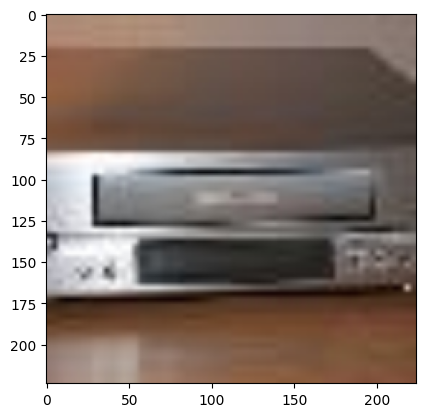

In [6]:
img = dataset[img_ID]["X"]
class_id = dataset[img_ID]["Y_class"]
Y = dataset[img_ID]["Y"]
print(img.shape, class_id, Y)
image = dataset.inv_transform(img).permute(1, 2, 0)
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.64].


(1, 224, 224, 3)

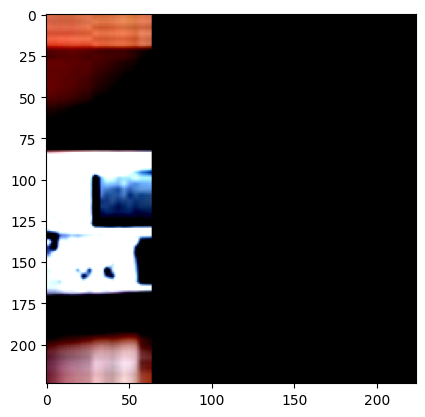

In [7]:
layer1 = layer(img, 1)
layer2 = layer(img, 2)
layer3 = layer(img, 3)
layer4 = layer(img, 4)
layer1.mask_image([0])
# plt.imshow(dataset.inv_transform(torch.Tensor(layer1.masked_image)).permute(1, 2, 0))
plt.imshow(torch.Tensor(layer1.masked_image).permute(1, 2, 0))
# exp_result = np.load(f'./scores_{img_ID}.npy')
exp_result = np.load('results/shap/Resnet50onImageNet/value/P1_n02988304.npy')
exp_result.shape

---

In [8]:
result_show = exp_result[0].sum(axis=-1)

In [9]:
image_show = image.mean(axis=-1)

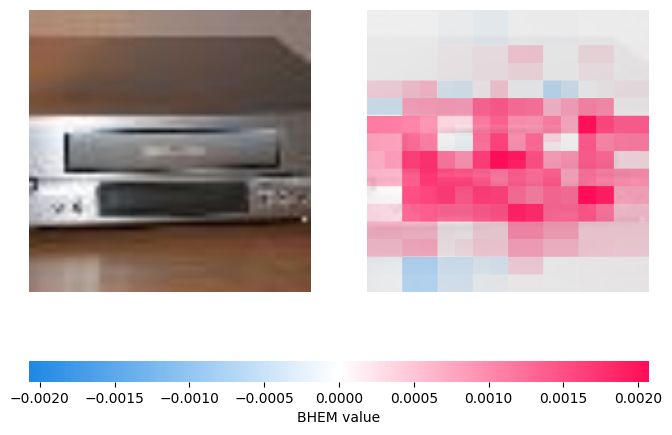

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6), squeeze=False)
axes[0,0].imshow(image)
axes[0][0].axis('off')
max_val = np.nanpercentile(np.abs(result_show), 99.9)
axes[0][1].imshow(image_show, cmap=plt.get_cmap('gray'), alpha=0.15)
axes[0][1].imshow(result_show, cmap=red_transparent_blue, vmin=-max_val,vmax=max_val)
axes[0][1].axis('off')
im = axes[0, 1].imshow(result_show, cmap=red_transparent_blue, vmin=-max_val, vmax=max_val)

cb = plt.colorbar(im, ax=np.ravel(axes).tolist(), label="BHEM value", orientation="horizontal", aspect=30)
cb.outline.set_visible(False)
plt.show()